- 이번에는 **구조**를 바꿔서 Dropout 부분을 제거하고
- focal_loss는 이전 `12_drowsiness_cls(focal_gamma3.0).ipynb` 파일에서 사용한 gamma=2.0, alpha=0.25를 이용한다.  
- 이로 open class recall을 조금 회복하면서 overfitting을 완화해보자.  

In [1]:
import os, random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("GPU 사용 가능 여부:", tf.config.list_physical_devices("GPU"))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-06-13 16:44:04.769647: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 16:44:04.859121: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-13 16:44:04.859273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-13 16:44:04.868737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 16:44:04.902797: I tensorflow/core/platform/cpu_feature_guar

GPU 사용 가능 여부: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        epsilon=K.epsilon()
        y_pred=K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true*K.log(y_pred) - (1 - y_true)*K.log(1 - y_pred)
        weight = alpha*y_true*K.pow(1 - y_pred, gamma) + \
                 (1 - alpha)*(1 - y_true)*K.pow(y_pred, gamma)

        return K.mean(weight * cross_entropy, axis=-1)
    return loss

In [3]:
IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [4]:
# Dropout을 사용하지 않고, l2 정규화 + focal loss를 적용한 모델
model=Sequential([
    Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(96, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss=focal_loss(gamma=2.0, alpha=0.25),
              metrics=["accuracy"])

2025-06-13 16:45:08.463132: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 16:45:08.463217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 16:45:08.463251: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 16:45:08.657693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 16:45:08.657775: I external/local_xla/xla/stream_executor

In [5]:
history=model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1)

Epoch 1/20


2025-06-13 16:45:26.753527: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-13 16:45:26.836998: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-06-13 16:45:26.837038: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-06-13 16:45:26.837098: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-06-13 16:45:26.934005: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-06-13 16:45:27.353048: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kerne

1200/1200 [==============================] - 43s 34ms/step - loss: 0.1720 - accuracy: 0.8842 - val_loss: 0.0714 - val_accuracy: 0.8771
Epoch 2/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0412 - accuracy: 0.9368 - val_loss: 0.0648 - val_accuracy: 0.8046
Epoch 3/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0305 - accuracy: 0.9421 - val_loss: 0.0417 - val_accuracy: 0.8763
Epoch 4/20
1200/1200 [==============================] - 27s 22ms/step - loss: 0.0304 - accuracy: 0.9422 - val_loss: 0.1232 - val_accuracy: 0.7412
Epoch 5/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0238 - accuracy: 0.9563 - val_loss: 0.0955 - val_accuracy: 0.6669
Epoch 6/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0224 - accuracy: 0.9600 - val_loss: 0.3029 - val_accuracy: 0.5407
Epoch 7/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0204 - accuracy: 0.9660 - val_loss: 0.0451 - val_accura

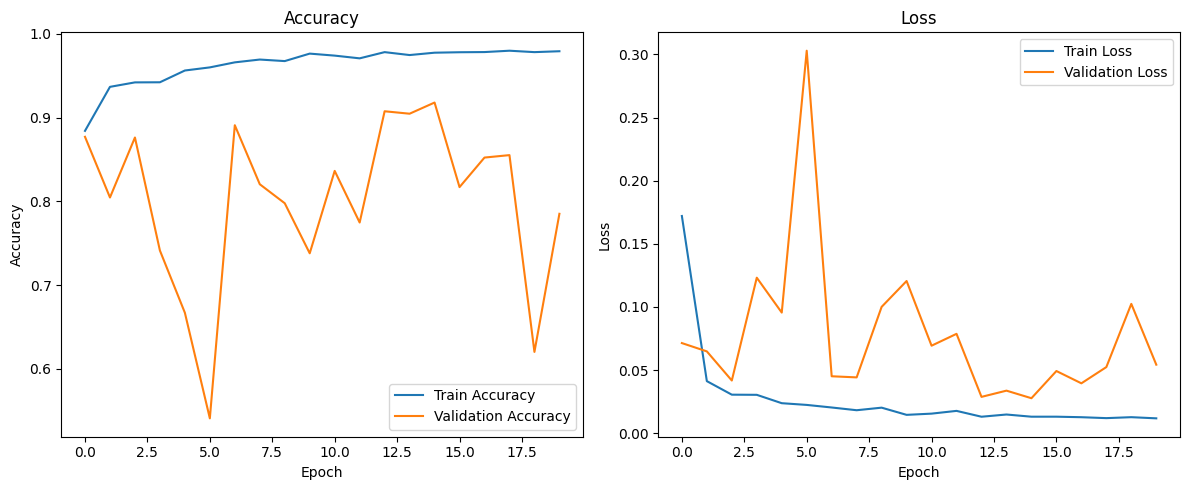

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/13_no_dropout_training_plot.png")
plt.show()

              precision    recall  f1-score   support

      closed       0.71      0.97      0.82      4800
        open       0.95      0.61      0.74      4800

    accuracy                           0.79      9600
   macro avg       0.83      0.79      0.78      9600
weighted avg       0.83      0.79      0.78      9600



2025-06-13 16:54:32.746175: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1766735148149880035


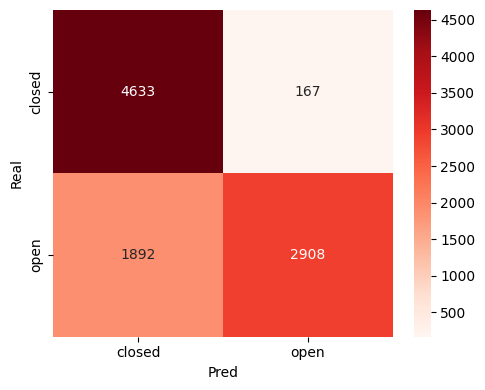

In [7]:
y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)

with open("../../results/reports/13_no_dropout_classification_report.txt", "w") as f:
    f.write(report)

conf_matrix=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/13_no_dropout_confusion_matrix.png")
plt.show()

오버피팅은 약간 나아졌지만, open recall이 낮음 -> 일반화 성능이 떨어짐  
다음 단계에서는 Dense 구조를 확장해보자.  